In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Configuração

In [2]:
FILENAME = 'razão-inconsistências-total-de-condições-fluxo-atual-vs-média-geral.csv'
MIN_SAMPLES = 5

Carregamento dos Dados e Limpeza

In [3]:
df = pd.read_csv(FILENAME)
df['time'] = pd.to_datetime(df['time'])

# Converte texto ("N/A") para NaN e depois para número
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df = df.dropna(subset=['value'])

# Extrair ID
df['flow_id'] = df['group'].apply(lambda x: x.split(':')[-1])

Normalização Temporal

In [4]:
start_times = df.groupby('flow_id')['time'].min().reset_index()
start_times.rename(columns={'time': 'start_time'}, inplace=True)

df_merged = pd.merge(df, start_times, on='flow_id')
df_merged['elapsed_hours'] = (df_merged['time'] - df_merged['start_time']).dt.total_seconds() / 3600
df_merged['hour_bin'] = df_merged['elapsed_hours'].round().astype(int)

Agregação

In [5]:
agg_data = df_merged.groupby('hour_bin')['value'].agg(['mean', 'std', 'count']).reset_index()

Identificar Ponto de Corte (Confiabilidade)

In [6]:
low_reliability = agg_data[agg_data['count'] < MIN_SAMPLES]
if not low_reliability.empty:
    cutoff_hour = low_reliability['hour_bin'].min()
else:
    cutoff_hour = agg_data['hour_bin'].max()

Plotagem

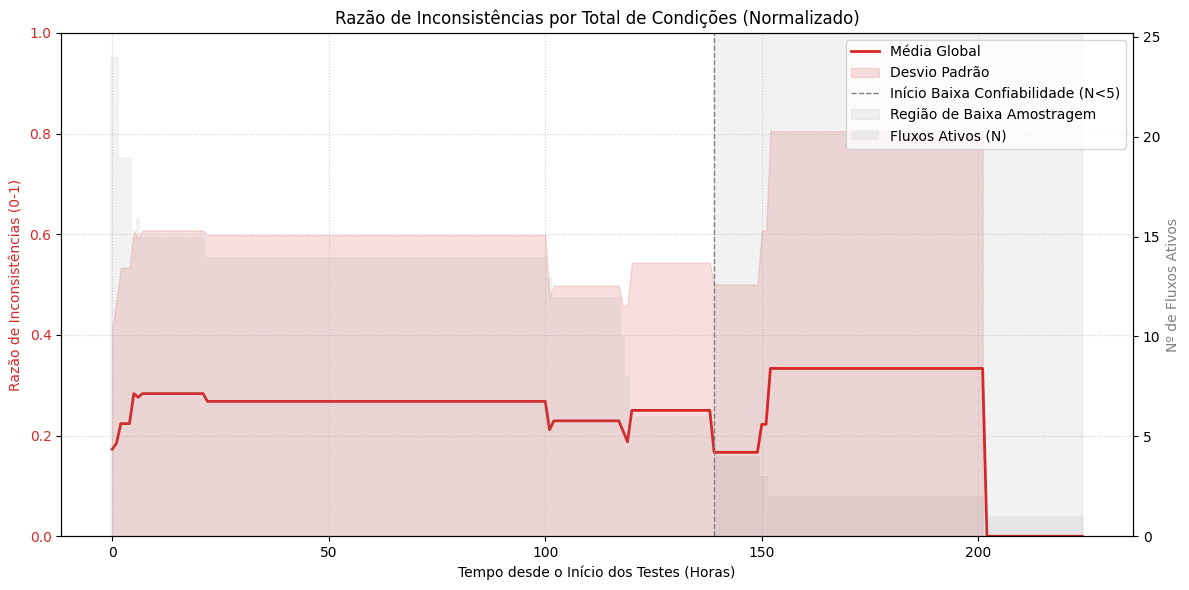

In [7]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# -- Eixo Principal --
ax1.plot(
    agg_data['hour_bin'],
    agg_data['mean'],
    label='Média Global',
    color='#d62728',
    linewidth=2
)
ax1.fill_between(agg_data['hour_bin'],
                 agg_data['mean'] - agg_data['std'],
                 agg_data['mean'] + agg_data['std'],
                 color='#d62728', alpha=0.15, label='Desvio Padrão')

# -- Indicadores de Confiabilidade --
plt.axvline(cutoff_hour,
            color='gray',
            linestyle='--',
            linewidth=1,
            label=f'Início Baixa Confiabilidade (N<{MIN_SAMPLES})')

plt.axvspan(cutoff_hour,
            agg_data['hour_bin'].max(),
            color='gray',
            alpha=0.1,
            label='Região de Baixa Amostragem')

# -- Eixo Secundário --
ax2 = ax1.twinx()
ax2.bar(agg_data['hour_bin'],
        agg_data['count'],
        color='gray',
        alpha=0.1,
        width=1,
        label='Fluxos Ativos (N)')

ax2.set_ylabel('Nº de Fluxos Ativos', color='gray')

# -- Formatação --
ax1.set_title('Razão de Inconsistências por Total de Condições (Normalizado)')
ax1.set_xlabel('Tempo desde o Início dos Testes (Horas)')
ax1.set_ylabel('Razão de Inconsistências (0-1)', color='#d62728')
ax1.tick_params(axis='y', labelcolor='#d62728')
ax1.set_ylim(0, 1.0)
ax1.grid(True, linestyle=':', alpha=0.6)

# Legenda
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()